In [ ]:
# get annotations - sentences

In [1]:
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np

In [2]:
from sklearn.cluster import KMeans

In [3]:
from pprint import pprint

In [4]:
from bert_serving.client import BertClient
bc = BertClient()

In [33]:
! conda install -y seaborn

Solving environment: done

## Package Plan ##

  environment location: /Users/wcz/opt/anaconda3/envs/labx

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.10.0             |             py_0         163 KB
    ------------------------------------------------------------
                                           Total:         163 KB

The following NEW packages will be INSTALLED:

  seaborn            pkgs/main/noarch::seaborn-0.10.0-py_0



seaborn-0.10.0       | 163 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [107]:
! conda install -y tensorboard

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /Users/wcz/opt/anaconda3/envs/labx

  added / updated specs:
    - tensorboard


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    absl-py-0.9.0              |           py37_0         164 KB
    grpcio-1.16.1              |   py37h044775b_1         840 KB
    markdown-3.1.1             |           py37_0         117 KB
    protobuf-3.11.2            |   py37h0a44026_0         625 KB
    tensorboard-2.0.0          |     pyhb38c66f_1         3.2 MB
    werkzeug-1.0.1             |             py_0         240 KB
    ------------------------------------------------------------
                                           Total:       

# load and encode annotations

In [ ]:
dataset_path = Path('../data/2017-06-22/')

In [ ]:
ann_paths = sorted([x for x in dataset_path.iterdir() if '_annotations.json' in x.name]); len(ann_paths)

In [ ]:
def get_annotations(x: Path):    
    annotations = eval(x.read_text(encoding='utf-8'))
    sample_id = int(x.name[:5])
    dicts = [{'sample_id': sample_id, 'annotation': a} for a in annotations]    
    return dicts

flatten = lambda l: [item for sublist in l for item in sublist]

ann_dicts = flatten([get_annotations(x) for x in tqdm(ann_paths[:])])

annotations_df = pd.DataFrame(ann_dicts)
print(len(annotations_df))
annotations_df.head()

In [ ]:
# create sentence encodings with bert

In [ ]:
encodings = bc.encode(annotations_df.annotation.to_list()[:])
encodings.shape

In [ ]:
# save, then load dataset

In [ ]:
annotations_df2 = annotations_df

In [ ]:
# annotations_df2['encoding'] = 
encodings_list = [encodings[x] for x in range(encodings.shape[0])]
annotations_df2['encoding'] = encodings_list
annotations_df2.head()

In [ ]:
dataset_path2 = Path('../data')

In [ ]:
annotations_df2.to_pickle(str(dataset_path2/'annotations.pkl'))
annotations_df2.to_csv(str(dataset_path2/'annotations.csv'))

# load dataset with encodings

In [5]:
dataset_path2 = Path('../data')

In [6]:
annotations_df2 = pd.read_pickle(str(dataset_path2/'annotations.pkl'))

# do clustering

In [7]:
ann_df = annotations_df2.iloc[:]

In [8]:
ann_df

sample_id                                         annotation  \
0             1                      A person is walking forwards.   
1             2                    A person walks 4 steps forward.   
2             3                                    A human walking   
3             4            A person walks forward at medium speed.   
4             4                          human slowly goes forward   
...         ...                                                ...   
6348       3961        a person running and stepipng over one step   
6349       3962                    A person runs straight forward.   
6350       3964  A person is sprinting up and down a small hill...   
6351       3965  A person runs forward, briefly touches the gro...   
6352       3966  a person stumbles on the ground but gets up an...   

                                               encoding  
0     [-0.15791105, -0.016321294, -0.018729901, -0.4...  
1     [-0.1540823, -0.13345166, 0.07930961, -0.23958...  
2     [-0.14400074, -0.495848, -0.48444295, 0.011635...  
3     [-0.21677037, -0.22117159, 0.023956455, -0.338...  
4     [-0.58368725, -0.18312697, 0.29863808, -0.1279...  
...                                                 ...  
6348  [-0.47801474, -0.1861707, 0.11223907, 0.024005...  
6349  [-0.08496222, -0.15005654, -0.46497947, -0.143...  
6350  [-0.30929312, -0.17201833, -0.26598853, 0.0950...  
6351  [-0.16391394, 0.08974507, -0.103834555, 0.0485...  
6352  [-0.1882587, -0.2696758, 0.25785556, 0.2424595...  

[6353 rows x 3 columns]

In [9]:
X = np.stack(ann_df.encoding.to_numpy(), axis=0)
X.shape

(6353, 768)

In [12]:
true_k = 20
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=20, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
clusters = model.labels_.tolist()
len(clusters)

6353

In [14]:
# analyze/visualize clusters

In [52]:
# Y_df = ann_df.sample(100)
Y_df = ann_df
# Y = bc.encode(Y_df.annotation.to_list())
Y = X

In [59]:
prediction = model.predict(Y)
print(prediction)

ann_df['pred'] = prediction

[10  4 16 ... 19 11 11]


In [54]:
Y_anns = Y_df.annotation.to_list(); Y_anns[:5]

['A person is walking forwards.',
 'A person walks 4 steps forward.',
 'A human walking',
 'A person walks forward at medium speed.',
 'human slowly goes forward']

In [55]:
preds = [(ann, prediction[idx]) for idx, ann in enumerate(Y_anns)]; preds[:5]

[('A person is walking forwards.', 10),
 ('A person walks 4 steps forward.', 4),
 ('A human walking', 16),
 ('A person walks forward at medium speed.', 10),
 ('human slowly goes forward', 0)]

In [57]:
for x in range(1, true_k+1):
    pprint([p for p in preds if p[1]==x][:20])
    print()

[('A person is turning right while walking', 1),
 ('A person is walking a left-turn', 1),
 ('Someone walks a right circle.', 1),
 ('Someone walks a left turn', 1),
 ('A human makes a left turn.', 1),
 ('A person goes left around a corner', 1),
 ('The human perfoms a left turn', 1),
 ('A person walking a left turn', 1),
 ('A person is turning right.', 1),
 ('a person walks in a right turn', 1),
 ('the person is making a wide turn to the right', 1),
 ('someone slowly turns a right corner.', 1),
 ('A person walks in a curve to the right.', 1),
 ('A person turns right.', 1),
 ('A person turns right.', 1),
 ('A person walks slowly a right curve', 1),
 ('A person turns left.', 1),
 ('A person turns left.', 1),
 ('A person walks a curve to the left', 1),
 ('Someone walks a left turn', 1)]

[('A person walking backwards for a few steps.', 2),
 ('Someone moves forward in a slow walk', 2),
 ('A human is walking backwards tilting its head a little bit beforehand', 2),
 ('a person walds backwards 

# reduce dimensionality

In [37]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:])

In [38]:
tsne_df

array([[ 12.80067  ,   6.879026 ],
       [-10.340662 ,  15.546744 ],
       [ 35.204586 ,  39.409412 ],
       ...,
       [  6.007216 ,  -3.1036053],
       [ -7.4863935,  -7.0460715],
       [ -2.2256038,  -1.8647115]], dtype=float32)

In [26]:
# visualize

In [28]:
# pick, and refine centroids/classes

In [81]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import seaborn as sns

# PCA

In [84]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X[:])

In [86]:
df = ann_df

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.1129121  0.06997789 0.0603395 ]


In [87]:
df

sample_id                                         annotation  \
0             1                      A person is walking forwards.   
1             2                    A person walks 4 steps forward.   
2             3                                    A human walking   
3             4            A person walks forward at medium speed.   
4             4                          human slowly goes forward   
...         ...                                                ...   
6348       3961        a person running and stepipng over one step   
6349       3962                    A person runs straight forward.   
6350       3964  A person is sprinting up and down a small hill...   
6351       3965  A person runs forward, briefly touches the gro...   
6352       3966  a person stumbles on the ground but gets up an...   

                                               encoding   pca-one   pca-two  \
0     [-0.15791105, -0.016321294, -0.018729901, -0.4... -0.876952 -2.566780   
1     [-0.1540823, -0.13345166, 0.07930961, -0.23958...  1.085089 -2.060924   
2     [-0.14400074, -0.495848, -0.48444295, 0.011635... -3.663655 -1.073543   
3     [-0.21677037, -0.22117159, 0.023956455, -0.338...  0.352793 -2.244833   
4     [-0.58368725, -0.18312697, 0.29863808, -0.1279... -0.018055 -0.615932   
...                                                 ...       ...       ...   
6348  [-0.47801474, -0.1861707, 0.11223907, 0.024005... -0.654281 -0.019917   
6349  [-0.08496222, -0.15005654, -0.46497947, -0.143... -0.906038 -3.125978   
6350  [-0.30929312, -0.17201833, -0.26598853, 0.0950...  0.308820 -0.814009   
6351  [-0.16391394, 0.08974507, -0.103834555, 0.0485...  1.052023  1.426824   
6352  [-0.1882587, -0.2696758, 0.25785556, 0.2424595... -0.132135  0.793516   

      pca-three  pred  
0      0.522601    10  
1     -0.038655     4  
2     -1.774162    16  
3      0.378608    10  
4     -1.548018     0  
...         ...   ...  
6348  -1.186598    18  
6349  -0.151614    10  
6350  -0.539769    19  
6351  -0.737092    11  
6352  -0.580014    11  

[6353 rows x 7 columns]

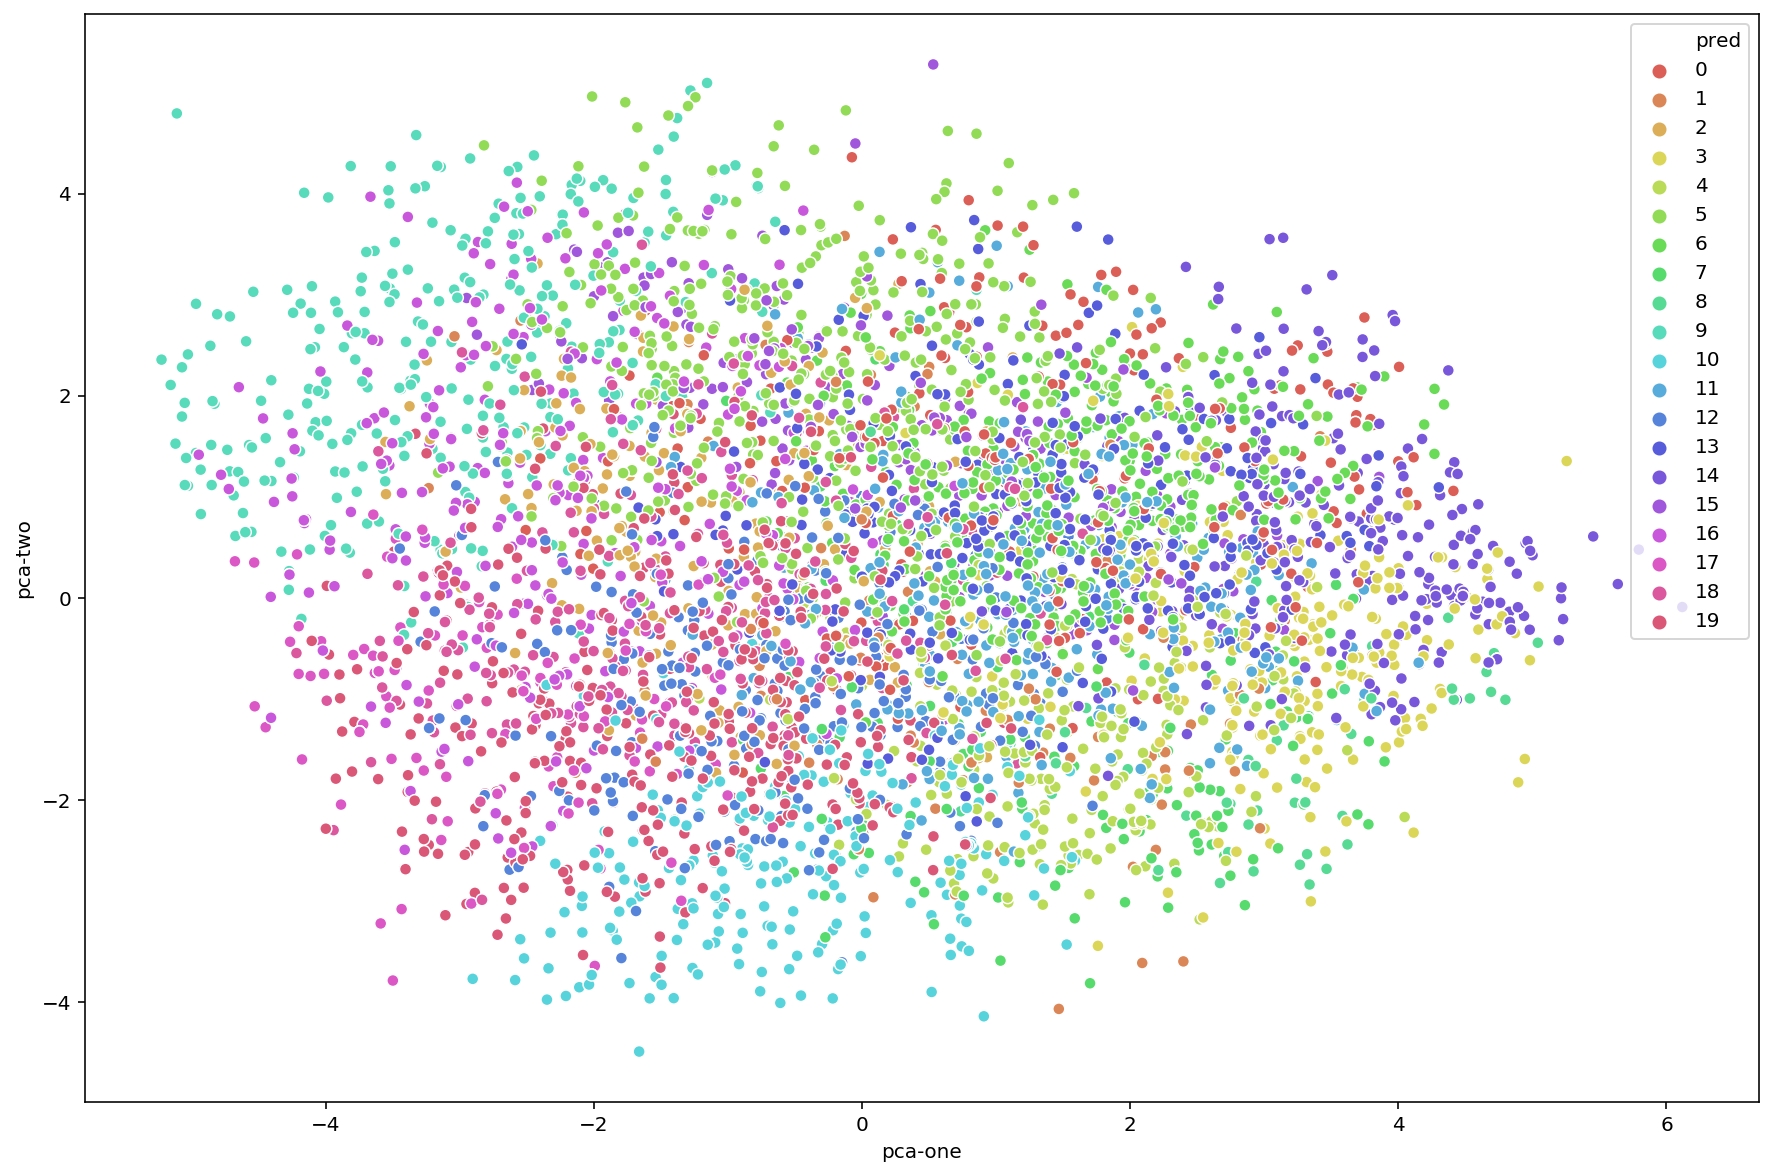

In [88]:
# plt.figure(figsize=(30,20))
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=df, #df.loc[0,:],
#     data=tsne_df,
    legend="full",
    alpha=1.0 #0.3
)

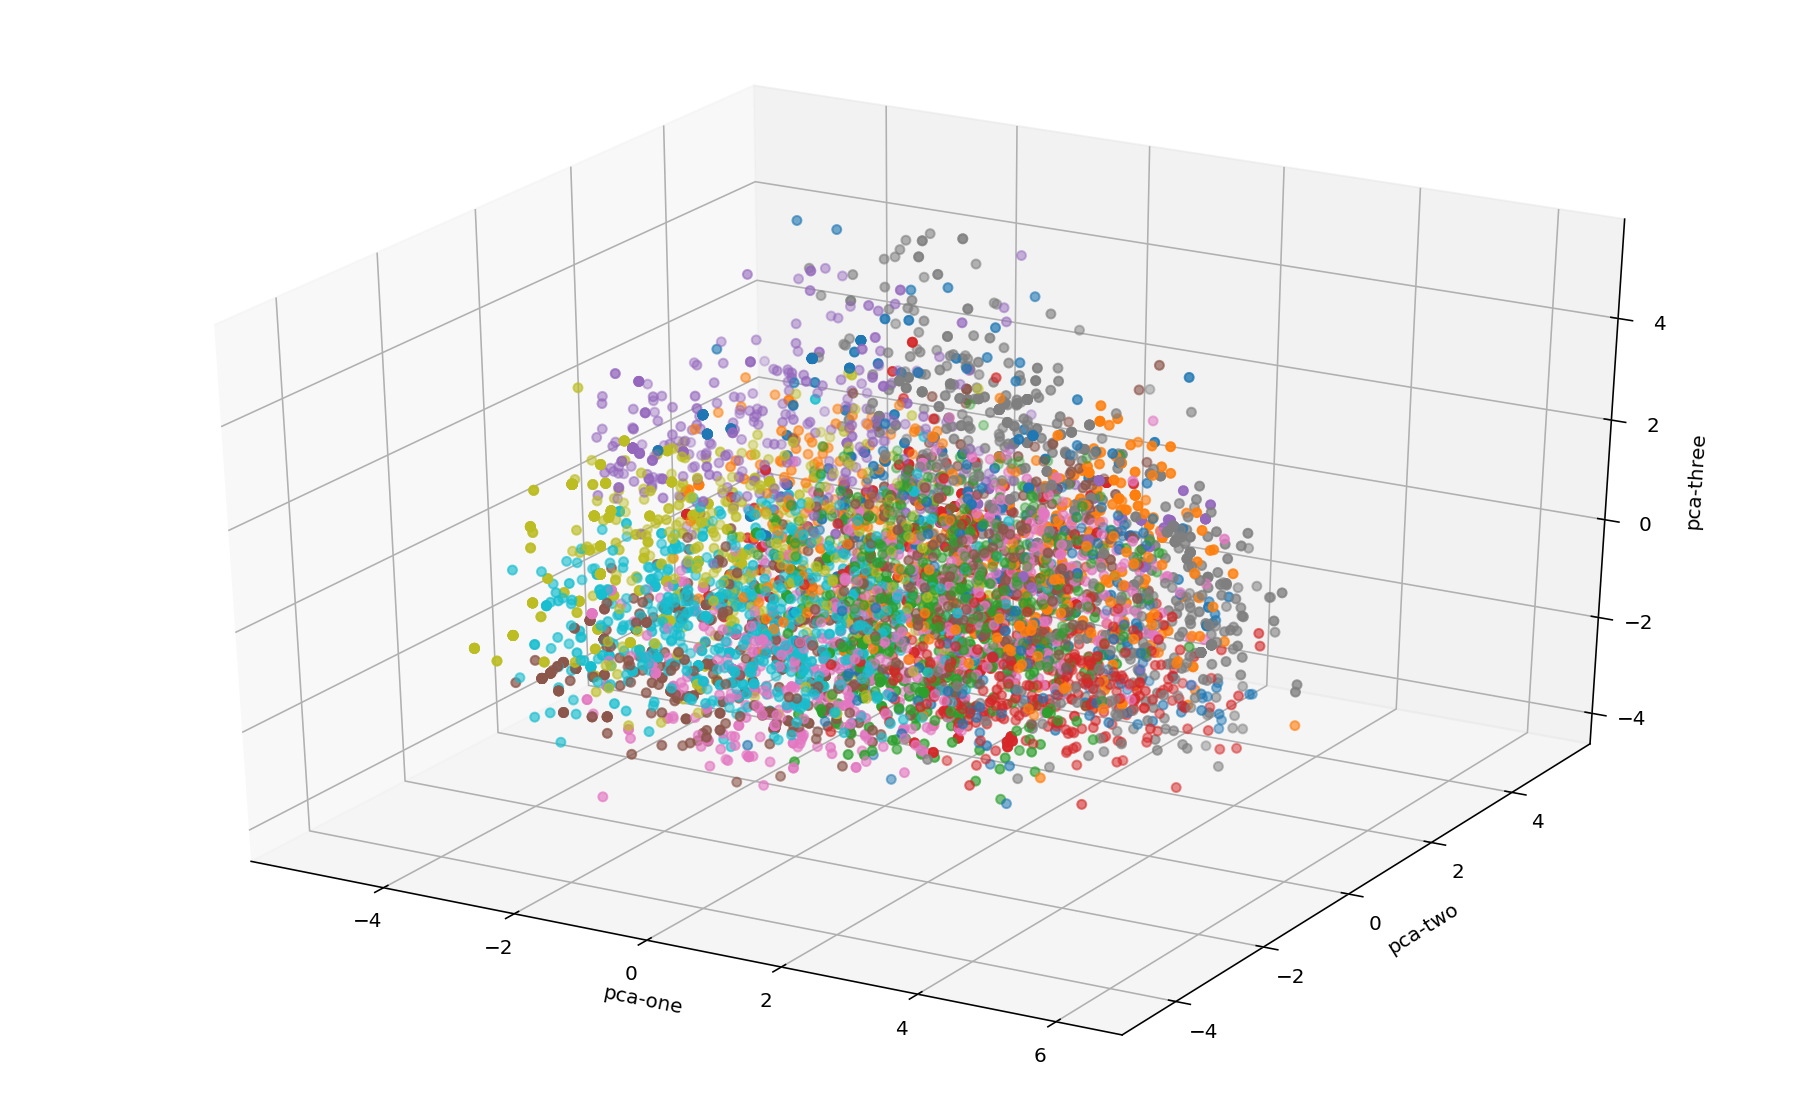

In [89]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["pred"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# T-SNE

In [92]:
import time

In [113]:
# Plot the centroids as a white X
centroids = model.cluster_centers_
centroids.shape

(20, 768)

In [118]:
X.shape

(6353, 768)

In [121]:
# TODO: append centroids, and then separate them
Xprim = np.concatenate([X, centroids], axis=0)
Xprim.shape

(6373, 768)

In [125]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_prim = tsne.fit_transform(Xprim[:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6373 samples in 0.251s...
[t-SNE] Computed neighbors for 6373 samples in 51.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6373
[t-SNE] Computed conditional probabilities for sample 2000 / 6373
[t-SNE] Computed conditional probabilities for sample 3000 / 6373
[t-SNE] Computed conditional probabilities for sample 4000 / 6373
[t-SNE] Computed conditional probabilities for sample 5000 / 6373
[t-SNE] Computed conditional probabilities for sample 6000 / 6373
[t-SNE] Computed conditional probabilities for sample 6373 / 6373
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.330994
[t-SNE] KL divergence after 300 iterations: 2.375328
t-SNE done! Time elapsed: 56.47826814651489 seconds


In [126]:
tsne_results = tsne_results_prim[:6353, :]
centroids_results = tsne_results_prim[6353:, :]
tsne_results.shape, centroids_results.shape

((6353, 2), (20, 2))

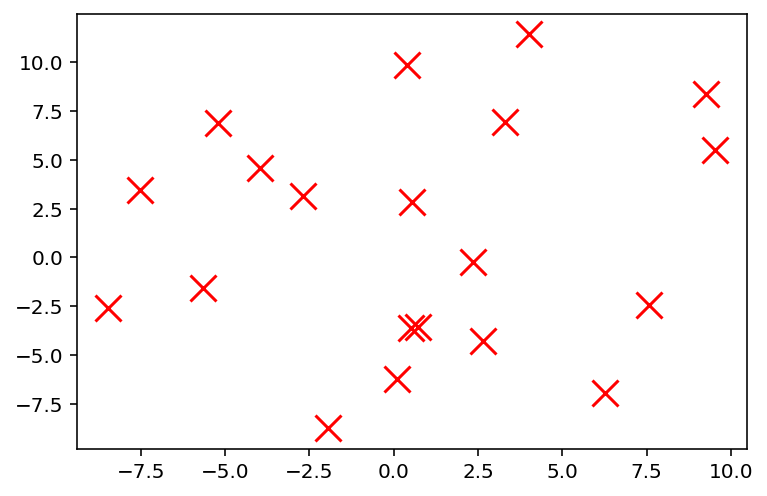

In [129]:
plt.scatter(centroids_results[:, 0], centroids_results[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

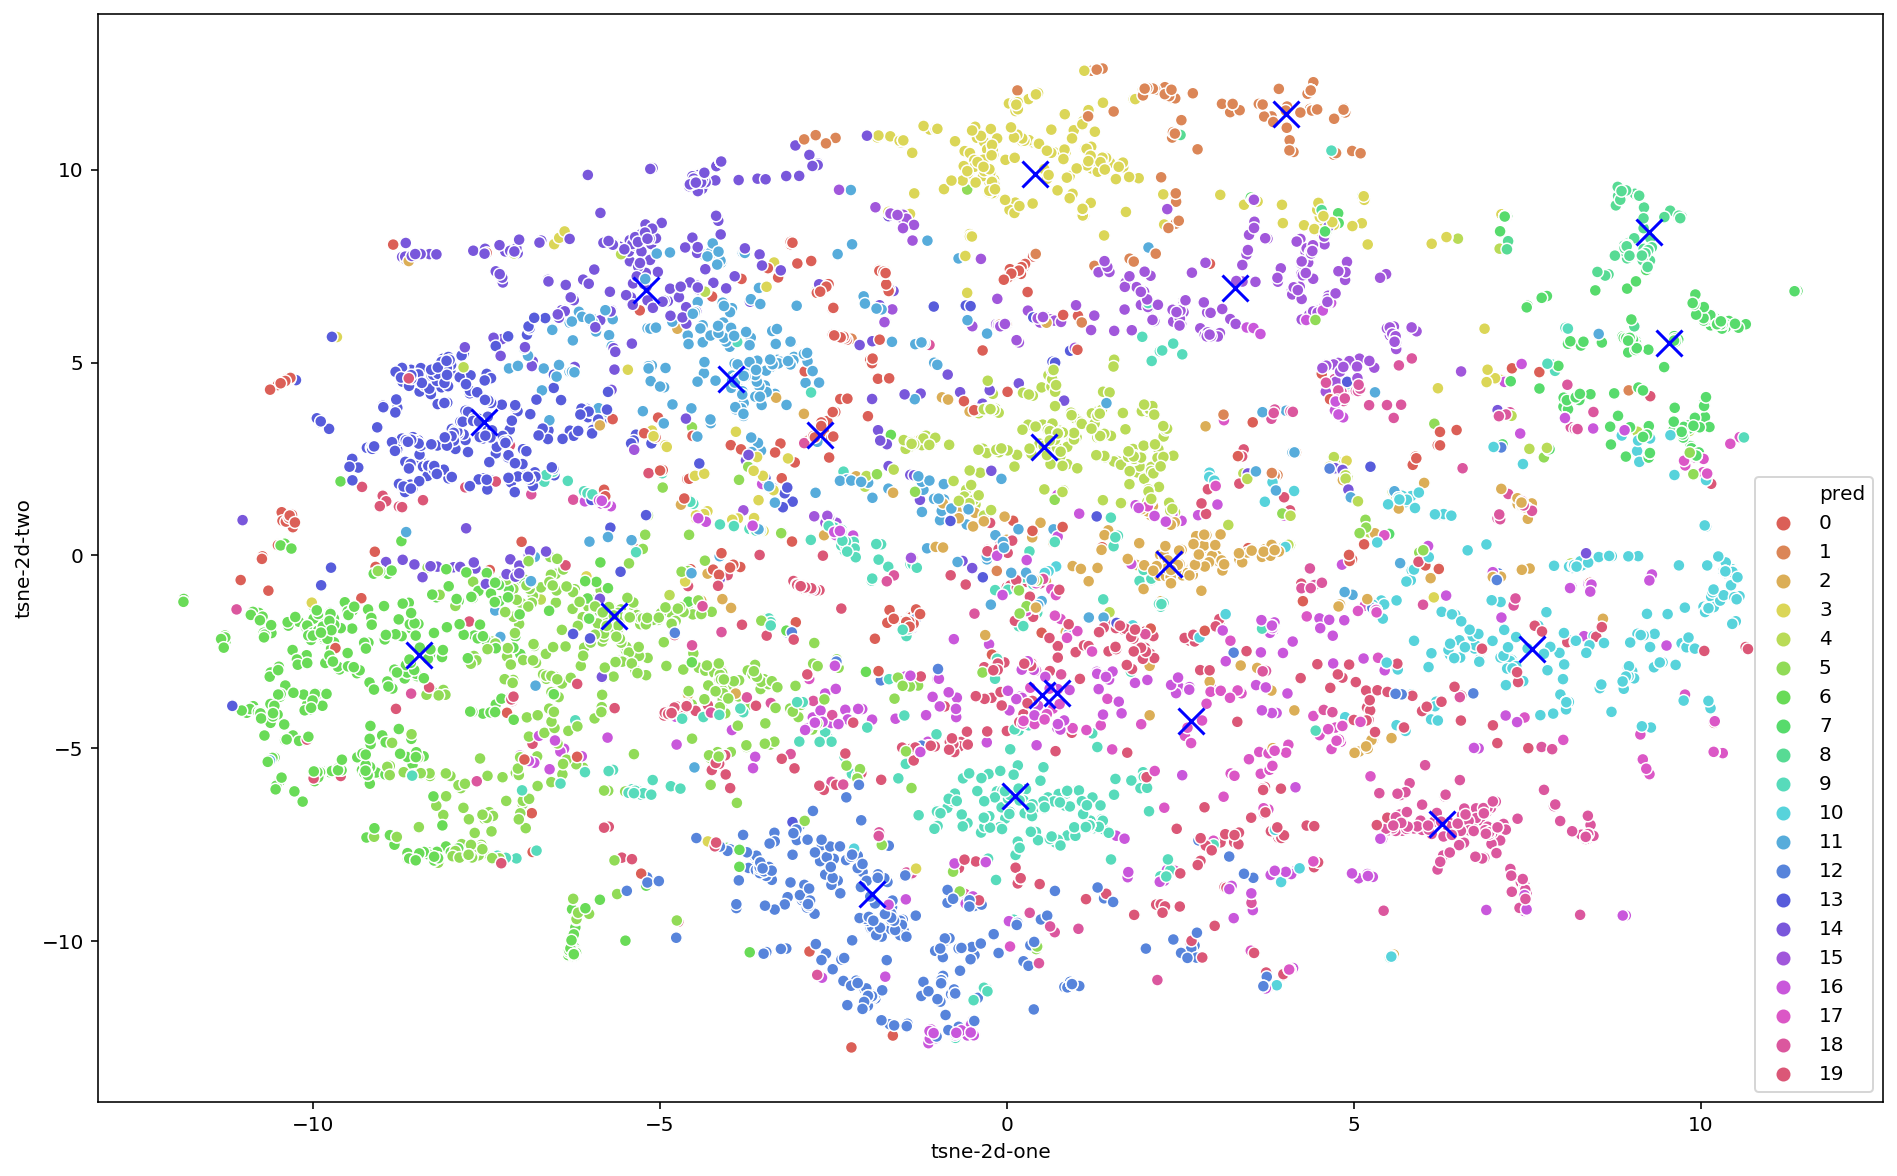

In [134]:
df_subset = df
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

# plot centroids
plt.scatter(centroids_results[:, 0], centroids_results[:, 1],
            marker='x', s=169, linewidths=5,
            color='b', zorder=10)

# plot samples
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=df_subset,
    legend="full",
    alpha=1.0
)

In [ ]:
# cont.d

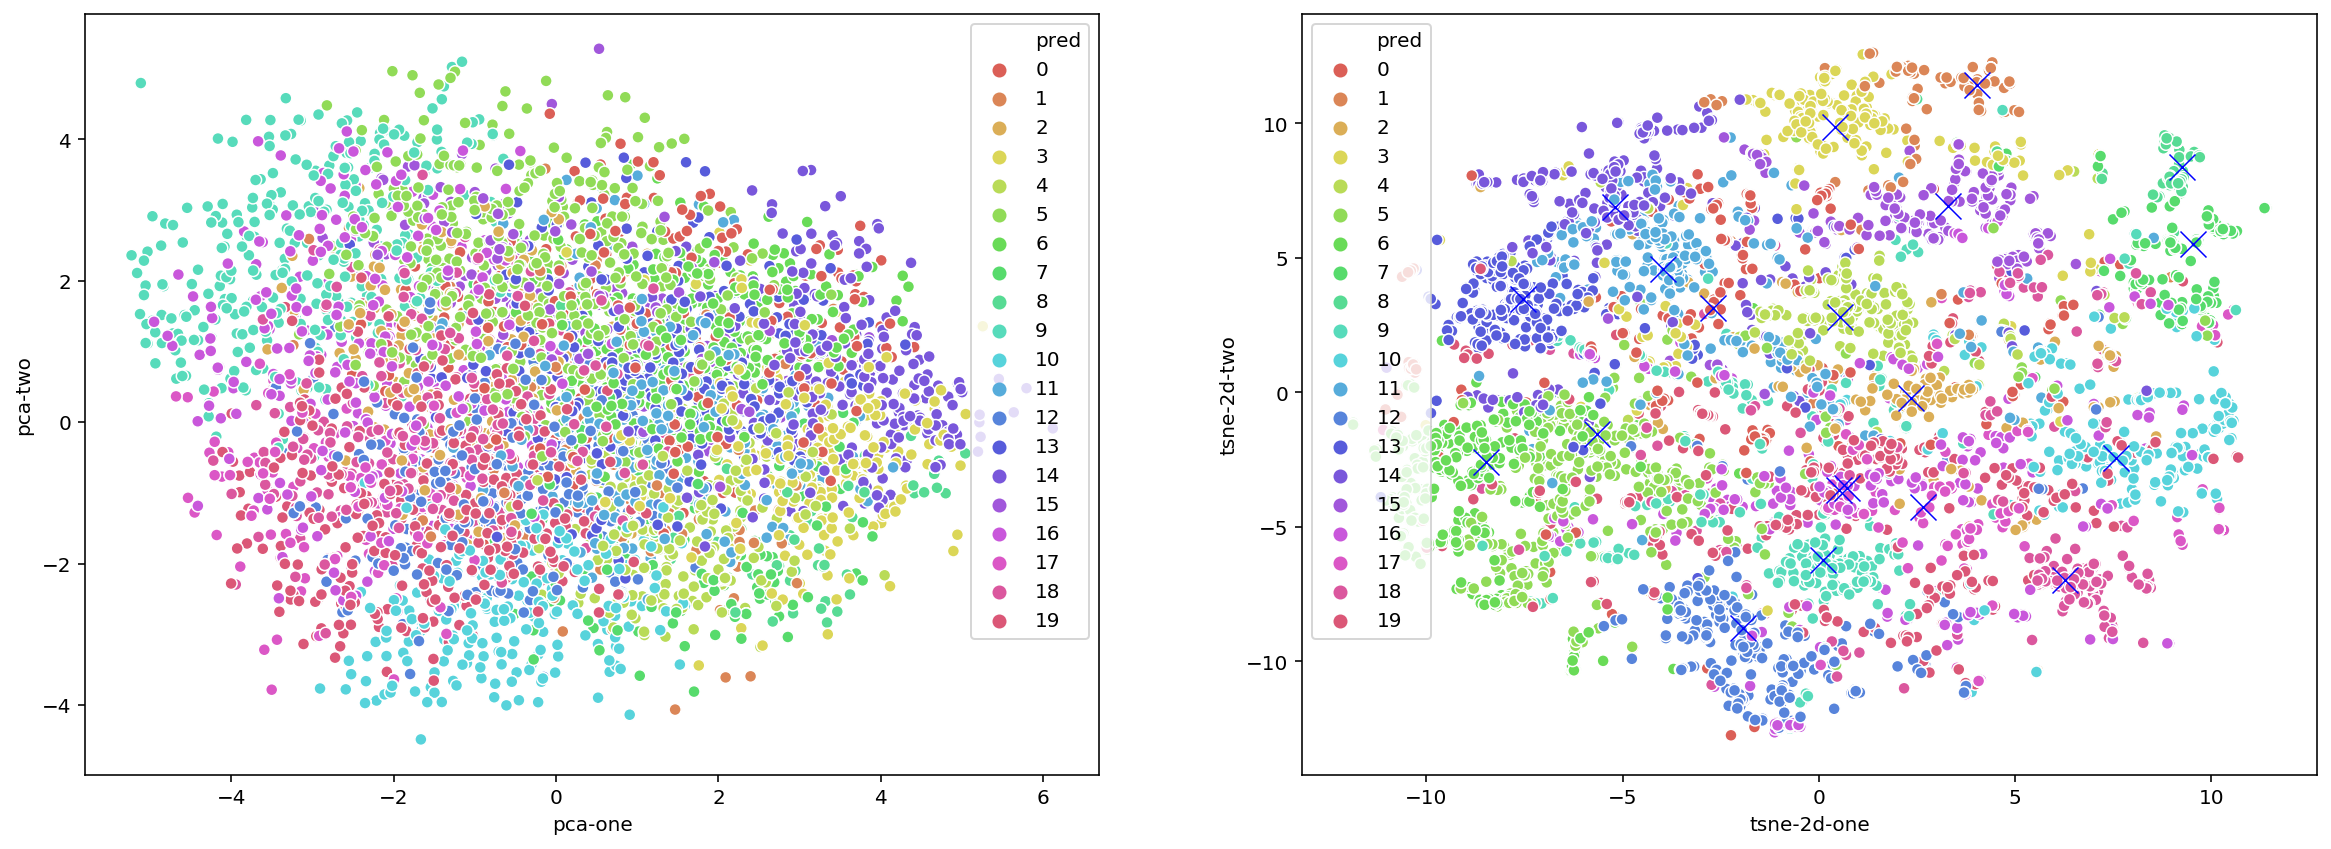

In [137]:
plt.figure(figsize=(20,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=df_subset,
    legend="full",
    alpha=1.0,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(centroids_results[:, 0], centroids_results[:, 1],
            marker='x', s=169, linewidths=5,
            color='b', zorder=10, ax=ax2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=df_subset,
    legend="full",
    alpha=1.0,
    ax=ax2
)